In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import  SP_Learner, interpolate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')
rc("text", usetex=False)
matplotlib.rcParams.update({'font.size': 14})
sns.set(font_scale = 2)

model_select =  ['SPATIAL', 'CNN', 'LSTM']


/Users/fearghalodonncha/opt/anaconda3/envs/lale/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/Users/fearghalodonncha/opt/anaconda3/envs/lale/lib/python3.9/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


# Select which models to run
Choice are `['SPATIAL', 'CNN', 'LSTM']` and default is that all models are run

In [2]:
model_select =  ['SPATIAL']

# Select which dataset to run for [ADCP, Temperature, or Dissolved oxygen]

In [ ]:
['ADCP_sensor_', 'Oxygen_Sensor', 'Temp_Sensor']
ts_stem = 'ADCP_sensor_' 


In [3]:
train_split, test_split = .8 ,1 # We allocate 80% for training and remaining 20% for test
root = '.'
result = root + '/Results/'
Out = root + "/30min_Data/"
error_folder = './errors/'


if 'ADCP' in ts_stem:
    sensor_idx = [2,4]
else:
    sensor_idx = [1,8,9]

#load Temperature data from the local file
# The data is resampled with a 30 minutes range
# pick 80%-100% to test
Temp = []
data = pd.DataFrame()
file_name = '../sensor_data/interpolated_data' + ts_stem
for i in sensor_idx: # We have data quality issues with the other sensors
    df = pd.read_csv(file_name+str(i)+'.csv',index_col="observed_timestamp", parse_dates=True)
    data = data.append(df)
    s = df.size
    print('data_length: ', s)
    df_train = df[:int(train_split*s)]
    df_train[np.isnan(df_train)]=-1.0
    df_test = df[int(train_split*s):int(test_split*s)]
    print(df_train.size, df_test.size)
    Temp.append(df.value.to_list()) # Creating a list of all sensor dataframes

data_length:  17520
14016 3504
data_length:  17520
14016 3504


In [4]:
nlag = 48
Temp_time = df.index[nlag:] # Why? 
test_Temp_time = Temp_time[int(train_split*(len(Temp_time))):]

print([len(Temp[i]) for i in range(len(Temp))])
l = min([len(Temp[i]) for i in range(len(Temp))])
# We want all sensors to begin at same time
Temp = [T[:l] for T in Temp]
print([len(Temp[i]) for i in range(len(Temp))])

if 'ADCP' in ts_stem:
    df = pd.DataFrame({'S1': Temp[0],
                'S2': Temp[1]})
else:
    df = pd.DataFrame({'S1': Temp[0],
            'S2': Temp[1],
            'S3': Temp[2]})
Temp_diff = df.diff(periods=nlag)[nlag:]
#dataset
Temp_diff = np.transpose(Temp_diff.to_numpy())


NameError: name 'nlag' is not defined

# Model parameters

In [ ]:
#training info
train_time = 6
predict_time = 1
predict_position = 47
Stride = 1
epoches = 100
batch_size = 512

In [8]:
#SPATIAL -------------------------- model training 
if 'SPATIAL' in model_select:
    name = '_Temp_diff_' + 'SPATIAL'
    tp_py, tp_ty, tp_error, tp_std, tp_model = SP_Learner(Temp_diff, name,  train_split, test_split,  train_time, predict_time, 
                                                            predict_position, Stride, 0, epoches, run_model='SPATIAL',
                                                            batch_size=batch_size, plot=False)
    print('Temp SPATIAL MEAN: ', data.mean(), 'STD: ',data.std(), 'Skew: ', data.skew())

    #record the errors
    error_file = error_folder + name + '_error.txt'
    open(error_file, 'w').close()
    MAE = []
    MAPE = []
    STD = []
    with open(error_file, "a") as text_file:
        for i in range(len(tp_py)):
            mae = mean_absolute_error(tp_ty[i], tp_py[i])
            MAE.append(mae)
            mape = mean_absolute_percentage_error(tp_ty[i], tp_py[i])
            MAPE.append(mape)
            std = np.std(abs(tp_ty[i] - tp_py[i]))
            STD.append(std)
            info = 'Oxygen sensor {}:   mae: {:.4f},  std: {:.4f}, mape: {:.4f}'.format(i, mae, std, mape)
            text_file.write(info + "\n")
            print('mae: ', mae, 'std: ', std, 'mape: ', mape)
        info = 'Oxygen:   MAE: {:.4f},  STD: {:.4f}, MAPE: {:.4f}'.format(np.mean(MAE), np.mean(STD), np.mean(MAPE))
        text_file.write(info + "\n")

    #save predicted data
    test_time = test_Temp_time[47+6:]
    print(len(test_time), len(tp_ty[0]))
    for i in range(len(tp_py)):
        df = pd.DataFrame({'date': test_time,
                    'value': tp_py[i]})
    #    df.to_csv(root+'/prediction/' + ts_stem +str(sensor_idx[i])+'_SPATIAL_prediction.csv', index=False)

    ytest_spatial = tp_ty
    ypred_spatial = tp_py

########################Start##################################
we are acting on raw data 0
2 2
Training Data Length:  2 13977
Test Data Length:  2 3495
Training percentage:  25.005365958360166 %
Total data size:  2 17472
dat shape =  2 and  13977
train_hour = 6, test_hour = 1, and test_period = 47
(13924, 2, 6) (13924, 2, 1)
dat shape =  2 and  3495
train_hour = 6, test_hour = 1, and test_period = 47
(3442, 2, 6) (3442, 2, 1)
Train data size(batch, row, column) (13924, 2, 6) (13924, 2, 1)
test data size(batch, row, column) (3442, 2, 6) (3442, 2, 1)
Begin Stacked LSTM training
Data size for features (13924, 2, 6) and labels (13924, 2, 1)
input shape = (2, 6)


2022-03-11 13:20:21.745949: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
22/22 [==============================] - 8s 61ms/step - loss: 6.7256 - val_loss: 12.7001
Epoch 2/100
22/22 [==============================] - 1s 27ms/step - loss: 6.5266 - val_loss: 12.5552
Epoch 3/100
22/22 [==============================] - 1s 28ms/step - loss: 6.4255 - val_loss: 12.5440
Epoch 4/100
22/22 [==============================] - 1s 33ms/step - loss: 6.3734 - val_loss: 12.5822
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 6.3228 - val_loss: 12.5736
Epoch 6/100
22/22 [==============================] - 1s 29ms/step - loss: 6.2741 - val_loss: 12.6553
Epoch 7/100
22/22 [==============================] - 1s 27ms/step - loss: 6.2437 - val_loss: 12.7024
Epoch 8/100
22/22 [==============================] - 1s 27ms/step - loss: 6.2102 - val_loss: 12.8374
Epoch 9/100
22/22 [==============================] - 1s 26ms/step - loss: 6.1778 - val_loss: 12.7900
Epoch 10/100
22/22 [==============================] - 1s 23ms/step - loss: 6.1246 - val_los

KeyboardInterrupt: 

In [38]:
#CNN -------------------------- model training 
if 'CNN' in model_select:
    name = '_Temp_diff_' + 'CNN'
    tp_py, tp_ty, tp_error, tp_std, tp_model = SP_Learner(Temp_diff, name, train_split, test_split, train_time, predict_time, 
                                                        predict_position, Stride, 0, epoches, run_model='CNN',
                                                        batch_size=batch_size,  plot=False)

    print('Temp CNN MEAN: ', data.mean(), 'STD: ',data.std(), 'Skew: ', data.skew())

    #record the errors
    error_file = error_folder + name + '_error.txt'
    open(error_file, 'w').close()
    MAE = []
    MAPE = []
    STD = []
    with open(error_file, "a") as text_file:
        for i in range(len(tp_py)):
            mae = mean_absolute_error(tp_ty[i], tp_py[i])
            MAE.append(mae)
            mape = mean_absolute_percentage_error(tp_ty[i], tp_py[i])
            MAPE.append(mape)
            std = np.std(abs(tp_py[i] - tp_ty[i]))
            STD.append(std)
            info = 'Oxygen sensor {}:   mae: {:.4f},  std: {:.4f}, mape: {:.4f}'.format(i, mae, std, mape)
            text_file.write(info + "\n")
            print('mae: ', mae, 'std: ', std, 'mape: ', mape)
        info = 'Oxygen:   MAE: {:.4f},  STD: {:.4f}, MAPE: {:.4f}'.format(np.mean(MAE), np.mean(STD), np.mean(MAPE))
        text_file.write(info + "\n")

    #save predicted data
    test_time = test_Temp_time[47+6:]
    print(len(test_time), len(tp_ty[0]))

    for i in range(len(tp_py)):
        df = pd.DataFrame({'date': test_time,
                    'value': tp_py[i]})
        df.to_csv(root+'/prediction/' + ts_stem +str(sensor_idx[i])+'_CNN_prediction.csv', index=False)
    ytest_CNN = tp_ty
    ypred_CNN = tp_py


########################Start##################################
we are acting on raw data 0
2 2
Training Data Length:  2 13977
Test Data Length:  2 3495
Training percentage:  25.005365958360166 %
Total data size:  2 17472
dat shape =  2 and  13977
train_hour = 6, test_hour = 1, and test_period = 47
(13924, 2, 6) (13924, 2, 1)
dat shape =  2 and  3495
train_hour = 6, test_hour = 1, and test_period = 47
(3442, 2, 6) (3442, 2, 1)
Train data size(batch, row, column) (13924, 2, 6) (13924, 2, 1)
test data size(batch, row, column) (3442, 2, 6) (3442, 2, 1)
begin baseline CNN
shape of train_x is (13924, 2, 6) and train_y = (13924, 2, 1) and 13924
Time step = 13924 and num_features = 6
(13924, 6) (13924, 1)
Epoch 1/100
22/22 [==============================] - 1s 8ms/step - loss: 3.3975 - val_loss: 3.7404
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 3.3623 - val_loss: 3.7299
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 3.3494 - val_loss: 3.

<Figure size 432x288 with 0 Axes>

In [39]:
#LSTM -------------------------- model training 
if 'LSTM' in model_select:
    name = '_Temp_diff_' + 'CNN'
    tp_py, tp_ty, tp_error, tp_std, tp_model = SP_Learner(Temp_diff, name, train_split, test_split, train_time, predict_time, 
                                                        predict_position, Stride, 0, epoches, run_model='LSTM',
                                                        batch_size=batch_size,  plot=False)

    print('Temp LSTM MEAN: ', data.mean(), 'STD: ',data.std(), 'Skew: ', data.skew())

    #record the errors
    error_file = error_folder + name + '_error.txt'
    open(error_file, 'w').close()
    MAE = []
    MAPE = []
    STD = []
    with open(error_file, "a") as text_file:
        for i in range(len(tp_py)):
            mae = mean_absolute_error(tp_ty[i], tp_py[i])
            MAE.append(mae)
            mape = mean_absolute_percentage_error(tp_ty[i], tp_py[i])
            MAPE.append(mape)
            std = np.std(abs(tp_py[i] - tp_ty[i]))
            STD.append(std)
            info = 'Oxygen sensor {}:   mae: {:.4f},  std: {:.4f}, mape: {:.4f}'.format(i, mae, std, mape)
            text_file.write(info + "\n")
            print('mae: ', mae, 'std: ', std, 'mape: ', mape)
        info = 'Temperature:   MAE: {:.4f},  STD: {:.4f}, MAPE: {:.4f}'.format(np.mean(MAE), np.mean(STD), np.mean(MAPE))
        text_file.write(info + "\n")

    #save predicted data
    test_time = test_Temp_time[47+6:]
    print(len(test_time), len(tp_ty[0]))

    for i in range(len(tp_py)):
        df = pd.DataFrame({'date': test_time,
                    'value': tp_py[i]})
        df.to_csv(root+'/prediction/' + ts_stem +str(sensor_idx[i])+'_LSTM_prediction.csv', index=False)
    ytest_lstm = tp_ty
    ypred_lstm = tp_py



########################Start##################################
we are acting on raw data 0
2 2
Training Data Length:  2 13977
Test Data Length:  2 3495
Training percentage:  25.005365958360166 %
Total data size:  2 17472
dat shape =  2 and  13977
train_hour = 6, test_hour = 1, and test_period = 47
(13924, 2, 6) (13924, 2, 1)
dat shape =  2 and  3495
train_hour = 6, test_hour = 1, and test_period = 47
(3442, 2, 6) (3442, 2, 1)
Train data size(batch, row, column) (13924, 2, 6) (13924, 2, 1)
test data size(batch, row, column) (3442, 2, 6) (3442, 2, 1)
shape of train_x is (13924, 2, 6) and train_y = (13924, 2, 1) and 13924
At baseline LSTM shape X =(13924, 6) and Y = (13924, 1)
(13924, 6) (13924, 1)
Epoch 1/100
22/22 [==============================] - 2s 23ms/step - loss: 3.4152 - val_loss: 3.7426
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 3.3925 - val_loss: 3.7378
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 3.3732 - val_loss: 3.7

<Figure size 432x288 with 0 Axes>

(-1.0, 1.0)

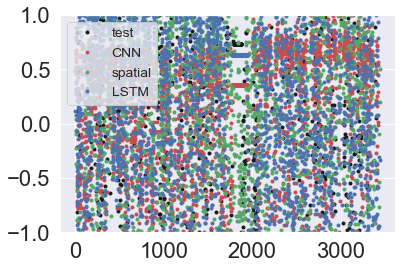

In [40]:
sel = 0
plt.plot(ytest_CNN[sel], 'k.', label = 'test')
plt.plot(ypred_CNN[sel], 'r.', label = 'CNN')
plt.plot(ypred_spatial[sel], 'g.', label = 'spatial')
plt.plot(ypred_lstm[sel], 'b.', label = 'LSTM')
plt.legend(loc = 'upper left',fontsize='xx-small')
plt.ylim([-1,1])
#plt.xlim([250,750])

In [41]:
for i in range(len(ytest_CNN)):
    mae_CNN = mean_absolute_error(ytest_CNN[i], ypred_CNN[i])
    mae_lstm = mean_absolute_error(ytest_CNN[i], ypred_lstm[i])
    mae_spatial = mean_absolute_error(ytest_CNN[i], ypred_spatial[i])
    print(i, mae_CNN, mae_lstm, mae_spatial)

0 3.6108765157490357 3.751555351593481 3.6147541925960534
1 5.5153789361585375 5.659415928945421 5.657689311941755


In [2]:
year = [year for year in range(1979, 2018)]
year

[1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]